# rqalpha

## Install 
`pip install -i https://pypi.douban.com/simple rqalpha`

## Download Bundle:

`rqalpha download-bundle`

In [3]:
!rqalpha download-bundle

try http://bundle.assets.ricequant.com/bundles_v4/rqbundle_202104.tar.bz2 ...
downloading ...  [####################################]  100%          
Data bundle download successfully in /Users/winshare/.rqalpha/bundle


## Config Generate

In [4]:
!rqalpha generate-config

Config file has been generated in /Users/winshare/workspace/Business/config.yml


In [8]:
!rqalpha update-bundle

rqdatac init failed with error: username/password/addr or uri expected


In [1]:
import os 
import yaml
config=open("/Users/winshare/workspace/Business/config.yml","r",encoding="utf-8")
config_data = yaml.load(config)
for k,v in config_data.items():
    if type(v) is dict:
        print("|-",k)
        for kk,vv in v.items():
            print("    |-",kk,":",vv)
    else:
        print("|-",k,":",v)
            

FileNotFoundError: [Errno 2] No such file or directory: '/Users/winshare/workspace/Business/config.yml'

# Strategy Sesign

在这个方法中编写任何的初始化逻辑。context对象将会在你的算法策略的任何方法之间做传递。
```python
def init(context):
    logger.info("init")
    context.s1 = "000001.XSHE"
    update_universe(context.s1)
    # 是否已发送了order
    context.fired = False
    context.cnt = 1


def before_trading(context):
    logger.info("Before Trading", context.cnt)
    context.cnt += 1
```

你选择的证券的数据更新将会触发此段逻辑，例如日或分钟历史数据切片或者是实时数据切片更新
```python
def handle_bar(context, bar_dict):
    context.cnt += 1
    logger.info("handle_bar", context.cnt)
    # 开始编写你的主要的算法逻辑

    # bar_dict[order_book_id] 可以拿到某个证券的bar信息
    # context.portfolio 可以拿到现在的投资组合状态信息

    # 使用order_shares(id_or_ins, amount)方法进行落单

    # TODO: 开始编写你的算法吧！
    if not context.fired:
        # order_percent并且传入1代表买入该股票并且使其占有投资组合的100%
        order_percent(context.s1, 1)
        context.fired = True
```

## 策略实践
### 单股票Golden Cross

In [7]:
import talib


# 在这个方法中编写任何的初始化逻辑。context对象将会在你的算法策略的任何方法之间做传递。
def init(context):
    context.s1 = "000001.XSHE"

    # 设置这个策略当中会用到的参数，在策略中可以随时调用，这个策略使用长短均线，我们在这里设定长线和短线的区间，在调试寻找最佳区间的时候只需要在这里进行数值改动
    context.SHORTPERIOD = 20
    context.LONGPERIOD = 120


# 你选择的证券的数据更新将会触发此段逻辑，例如日或分钟历史数据切片或者是实时数据切片更新
def handle_bar(context, bar_dict):
    # 开始编写你的主要的算法逻辑

    # bar_dict[order_book_id] 可以拿到某个证券的bar信息
    # context.portfolio 可以拿到现在的投资组合状态信息

    # 使用order_shares(id_or_ins, amount)方法进行落单

    # TODO: 开始编写你的算法吧！

    # 因为策略需要用到均线，所以需要读取历史数据
    prices = history_bars(context.s1, context.LONGPERIOD+1, '1d', 'close')

    # 使用talib计算长短两根均线，均线以array的格式表达
    short_avg = talib.SMA(prices, context.SHORTPERIOD)
    long_avg = talib.SMA(prices, context.LONGPERIOD)

    plot("short avg", short_avg[-1])
    plot("long avg", long_avg[-1])

    # 获取当前投资组合中股票的仓位
    cur_position = get_position(context.s1).quantity
    # 计算现在portfolio中的现金可以购买多少股票
    shares = context.portfolio.cash/bar_dict[context.s1].close

    # 如果短均线从上往下跌破长均线，也就是在目前的bar短线平均值低于长线平均值，而上一个bar的短线平均值高于长线平均值
    if short_avg[-1] - long_avg[-1] < 0 and short_avg[-2] - long_avg[-2] > 0 and cur_position > 0:
        # 进行清仓
        order_target_value(context.s1, 0)

    # 如果短均线从下往上突破长均线，为入场信号
    if short_avg[-1] - long_avg[-1] > 0 and short_avg[-2] - long_avg[-2] < 0:
        # 满仓入股
        order_shares(context.s1, shares)

# Back Test

In [8]:
from rqalpha.api import *
from rqalpha import run_func

In [12]:
config = {
  "base": {
    "start_date": "2020-06-01",
    "end_date": "2020-12-01",
    "benchmark": "000300.XSHG",
    "accounts": {
        "stock": 100000
    }
  },
  "extra": {
    "log_level": "error",
  },
  "mod": {
    "sys_progress": {
        "enabled": True,
        "show": True,
    },
    "sys_analyser": {
      "enabled": True,
      "plot": True
    }
  }
}

/Users/winshare/anaconda3/envs/workspace/lib/python3.7/site-packages/rqalpha/mod/rqalpha_mod_sys_analyser/plot.py:188: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.2f}%'.format(x * 100) for x in vals])


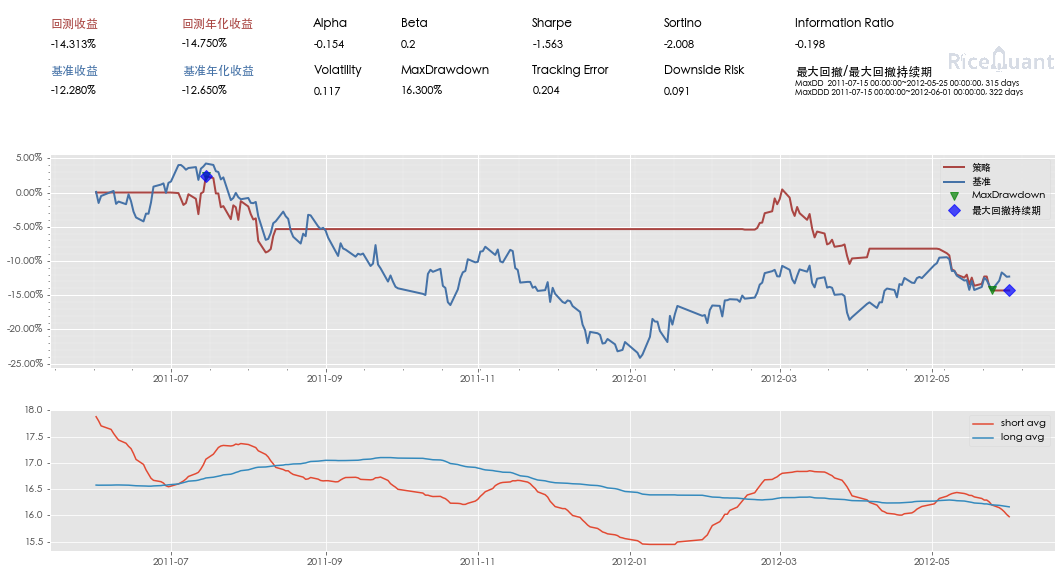

{'sys_analyser': {'summary': {'strategy_name': 'strategy',
   'start_date': '2011-06-01',
   'end_date': '2012-06-01',
   'strategy_file': 'strategy.py',
   'run_type': 'BACKTEST',
   'STOCK': 100000.0,
   'alpha': -0.154,
   'beta': 0.2,
   'sharpe': -1.563,
   'information_ratio': -0.198,
   'downside_risk': 0.091,
   'tracking_error': 0.204,
   'sortino': -2.008,
   'volatility': 0.117,
   'max_drawdown': 0.163,
   'total_value': 85686.5618,
   'cash': 85686.5618,
   'total_returns': -0.143134,
   'annualized_returns': -0.1475,
   'unit_net_value': 0.8569,
   'units': 100000.0,
   'benchmark_total_returns': -0.1228,
   'benchmark_annualized_returns': -0.1265},
  'trades':                         trading_datetime order_book_id symbol  side  \
  datetime                                                              
  2011-07-04 15:00:00  2011-07-04 15:00:00   000001.XSHE   平安银行   BUY   
  2011-08-12 15:00:00  2011-08-12 15:00:00   000001.XSHE   平安银行  SELL   
  2012-02-16 15:00:00  201

In [9]:
run_func(init=init, 
#          before_trading=before_trading, 
         handle_bar=handle_bar, 
         config=config
        )

# 多股票RSI
## 策略：
RSI= [上升平均数÷ (上升平均数+下跌平均数)]×100，或者RSI=100×RS/ (1+RS)，或者，RSI=100-100÷ (1+RS)。 

In [19]:


# 在这个方法中编写任何的初始化逻辑。context对象将会在你的算法策略的任何方法之间做传递。
def init(context):

    # 选择我们感兴趣的股票
    context.s1 = "600519.XSHG"
    context.s2 = "002049.XSHE"
    context.s3 = "688981.XSHG"
    context.s4 = "000063.XSHE"
    context.stocks = [context.s1, context.s2, context.s3]

    context.TIME_PERIOD = 14
    context.HIGH_RSI = 85
    context.LOW_RSI = 30
    context.ORDER_PERCENT = 0.3


# 你选择的证券的数据更新将会触发此段逻辑，例如日或分钟历史数据切片或者是实时数据切片更新
def handle_bar(context, bar_dict):
    # 开始编写你的主要的算法逻辑

    # bar_dict[order_book_id] 可以拿到某个证券的bar信息
    # context.portfolio 可以拿到现在的投资组合状态信息

    # 使用order_shares(id_or_ins, amount)方法进行落单

    # TODO: 开始编写你的算法吧！

    # 对我们选中的股票集合进行loop，运算每一只股票的RSI数值
    for stock in context.stocks:
        # 读取历史数据
        prices = history_bars(stock, context.TIME_PERIOD+1, '1d', 'close')

        # 用Talib计算RSI值
        rsi_data = talib.RSI(prices, timeperiod=context.TIME_PERIOD)[-1]

        cur_position = get_position(stock).quantity
        # 用剩余现金的30%来购买新的股票
        target_available_cash = context.portfolio.cash * context.ORDER_PERCENT

        # 当RSI大于设置的上限阀值，清仓该股票
        if rsi_data > context.HIGH_RSI and cur_position > 0:
            order_target_value(stock, 0)

        # 当RSI小于设置的下限阀值，用剩余cash的一定比例补仓该股
        if rsi_data < context.LOW_RSI:
            logger.info("target available cash caled: " + str(target_available_cash))
            # 如果剩余的现金不够一手 - 100shares，那么会被ricequant 的order management system reject掉
            order_value(stock, target_available_cash)

In [20]:
run_func(init=init, 
#          before_trading=before_trading, 
         handle_bar=handle_bar, 
         config=config
        )

[2020-06-01 15:00:00.000000] ERROR: user_system_log: 策略运行产生异常
Traceback (most recent call last):
  File "/Users/winshare/anaconda3/envs/workspace/lib/python3.7/site-packages/rqalpha/core/strategy.py", line 92, in handle_bar
    self._handle_bar(self._user_context, bar_dict)
  File "<ipython-input-19-5af1c2a64160>", line 32, in handle_bar
    prices = history_bars(stock, context.TIME_PERIOD+1, '1d', 'close')
  File "/Users/winshare/anaconda3/envs/workspace/lib/python3.7/site-packages/rqalpha/core/execution_context.py", line 112, in wrapper
    return func(*args, **kwargs)
  File "/Users/winshare/anaconda3/envs/workspace/lib/python3.7/site-packages/rqalpha/utils/arg_checker.py", line 439, in api_rule_check_wrapper
    with checker.check(func, args, kwargs):
  File "/Users/winshare/anaconda3/envs/workspace/lib/python3.7/contextlib.py", line 112, in __enter__
    return next(self.gen)
  File "/Users/winshare/anaconda3/envs/workspace/lib/python3.7/site-packages/rqalpha/utils/arg_checker.py"